# Purpose of this code

In [ ]:
# Install qmc if running in Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/fagonzalezo/qmc.git
else:
    import sys
    sys.path.insert(0, "../")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-brfx1x2b
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-brfx1x2b
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12755 sha256=79c2f1543293fb4be4011bbd3f13ce03e7df3a68aa0dfa7896bdbcfd390ec955
  Stored in directory: /tmp/pip-ephem-wheel-cache-ems016pc/wheels/bd/29/aa/e718040fd08e50166362474405988f9b9a9f8b2db6a7d75ed5
Successfully built qmc


In [ ]:
## Install calibration package
!pip install git+https://github.com/uu-sml/calibration.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/uu-sml/calibration.git to /tmp/pip-req-build-cxueopk0
  Running command git clone -q https://github.com/uu-sml/calibration.git /tmp/pip-req-build-cxueopk0
     |████████████████████████████████| 41 kB 647 kB/s 
  Created wheel for calibration: filename=calibration-0.0.1-py3-none-any.whl size=16891 sha256=e687b01fdbc1a0fca1a8a32af99f7941e39d0e1c8182b6e4687d9bbc78bca79d
  Stored in directory: /tmp/pip-ephem-wheel-cache-m9tvroe8/wheels/ea/67/e0/9f3de41456f07fb81268b88a9adad2069f4fc3b7dcab126433
Successfully built calibration


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import os
import shutil
import time

from sklearn import metrics
from sklearn import calibration
from scipy import stats as sp_stats

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

El paquete de _calibration_ tal cual como viene de github, no trae la carpeta de _utils_ donde están las distancias que se pueden utilizar. Adicionalmente, la inicialización del paquete no contiene nada, por lo cual se debe solucionar este problema con los siguientes.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
## Path in where files to fix clone of calibration module are
path_in = "/content/drive/MyDrive/Trabajo de Grado Maestría/Librería Calibration/"

## Path out where files to fix clone of calibration module have to be
path_out = "/usr/local/lib/python3.8/dist-packages/calibration/"

## Create folder 
if not os.path.isdir(path_out + "utils"):
  os.mkdir(path_out + "utils")

## Copy files
shutil.copyfile(path_in + "distances.py", path_out + "utils/distances.py")
shutil.copyfile(path_in + "__init__.py", path_out + "utils/__init__.py")

'/usr/local/lib/python3.8/dist-packages/calibration/utils/__init__.py'

In [ ]:
## Calibration functions
import calibration.stats as cali_stats
import calibration.utils as cali_utils
import calibration.binning as cali_binning
import calibration.sample as cali_sample
import calibration.lenses as cali_lenses

## QMC - RNA
import qmc.tf.layers as layers
import qmc.tf.models as models
import tensorflow as tf
from keras import backend

## Cleansing functions

In [ ]:
# One hot categorical variables
def getCatVariables(df, nom_cat):
  """
  Function to get one hot encoding for categorical variables based on the names
  in the dataframe.

  Return numpy array  
  """ 
  c = 0
  if len(nom_cat) > 0:
    for i in nom_cat:
      if c == 0:
        if np.unique(df[i]).shape[0] == 2:
          X_cat = np.where(df[i] == df[i].unique()[0],1,0).reshape(-1,1)
        else:
          X_cat = pd.get_dummies(df[i]).values
        c += 1
      else:
        if np.unique(df[i]).shape[0] == 2:
          X_cat = np.concatenate((X_cat, np.where(df[i] == df[i].unique()[0],1,0).reshape(-1,1)), axis = 1)
        else:
          X_cat = np.concatenate((X_cat, pd.get_dummies(df[i]).values) , axis = 1)
          c += 1
  else:
    X_cat = None
  return X_cat

# Combine numerical variables
def getNumVariables(df, nom_num):
  """
  Function to get the numerical variables based on the names in the dataframe.

  Return numpy array  
  """ 
  c = 0
  if len(nom_num) > 0:
    for i in nom_num:
      if c == 0:
        X_num = pd.to_numeric(df[i]).to_numpy().reshape(-1,1)
        c += 1
      else:
        X_num = np.concatenate((X_num, pd.to_numeric(df[i]).to_numpy().reshape(-1,1)), axis = 1)
        c += 1
  else:
    X_num = None

  return X_num

## Other functions

In [ ]:
#===========================================================#
#     Function to obtain probabilities from SVM model       #
#===========================================================#
def proba_svm(X, model):
  # pred = model.decision_function(X)
  # pred = (pred - pred.min())/(pred.max() - pred.min())
  # pred = np.concatenate((1-pred.reshape(-1,1), pred.reshape(-1,1)), axis = 1)

  pred = 1/(1 + np.exp(-model.decision_function(X)))
  pred = np.concatenate((1-pred.reshape(-1,1), pred.reshape(-1,1)), axis = 1)
  return pred

## Calibration functions

In [ ]:
#===================================#
#     Class-wise ECE for tensors    #    
#===================================#
def cwECE_tf(y_true, y_pred):
  n_bins = 15
  
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = 0.0

  ## Calculate ECE for each class
  for k in range(y_pred.shape[1]):
    ## Store probs and observations
    confidences = y_pred[:,k]
    accuracies = y_pred[:,k] == 1

    ece = 0.0
    # ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
      prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

      if prop_in_bin > 0:
          accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
          avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
          ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    ## Store values 
    ece_list += ece

  ece_list = ece_list/y_pred.shape[1]

  return ece_list

#========================================#
#   Maximum confidence ECE for tensors   #
#========================================#
def maxECE_tf(y_true, y_pred):
  n_bins = 15

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = tf.math.reduce_max(y_pred, axis = 1)
  predictions = tf.math.argmax(y_pred, axis = 1)
  accuracies = predictions == tf.math.argmax(y_true, axis = 1)

  ## Confidence and predictions in each bin
  ece = 0.0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
    prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

    if prop_in_bin > 0:
        accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
        avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
        ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      
  return ece

#================================#
#          Class-wise ECE        #
#================================#
def cwECE(n_bins, probs, obs, metric):
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = []

  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Calculate ECE for each class
  for k in range(probs.shape[1]):
    
    ## Store probs and observations
    confidences = probs[:,k]
    accuracies = obs[:,k] == 1

    ## Lists to store values to plot the reliability diagram
    conf = []
    acc = []
    bin = []

    ece = 0
    ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):       
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower)*(confidences <= bin_upper)      
      prop_in_bin = np.mean(in_bin)
      if prop_in_bin > 0:
        accuracy_in_bin = np.mean(accuracies[in_bin])
        avg_confidence_in_bin = np.mean(confidences[in_bin])
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        conf += [avg_confidence_in_bin]
        acc += [accuracy_in_bin]
        bin += [(bin_lower + bin_upper)/2]        
        del in_bin, prop_in_bin, accuracy_in_bin, avg_confidence_in_bin
    ## Store values
    conf_list += [conf]
    acc_list += [acc]
    bin_list += [bin]    
    ece_list += [ece]
    del conf, acc, bin, ece
  
  if metric is True:
    return np.mean(ece_list)
  else:
    return ece_list, conf_list, acc_list, bin_list

#================================#
#    Maximum confidence ECE      #
#================================#
def maxECE(n_bins, probs, obs, metric):
  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = probs.max(axis = 1)
  predictions = probs.argmax(axis = 1)
  accuracies = probs.argmax(axis = 1) == obs.argmax(axis = 1)

  ## Confidence and predictions in each bin
  ece = 0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower)*(confidences <= bin_upper)
    prop_in_bin = np.mean(in_bin)  

    if prop_in_bin > 0:
      accuracy_in_bin = np.mean(accuracies[in_bin])
      avg_confidence_in_bin = np.mean(confidences[in_bin])
      ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      conf_list += [avg_confidence_in_bin]
      acc_list += [accuracy_in_bin]
      bin_list += [(bin_lower + bin_upper)/2]   

  if metric is True:
    return ece
  else: 
    return ece, conf_list, acc_list, bin_list

#========================#
#   Brier multiclass     #
#========================#
def brier_multi(targets, probs):
  """ 
  targets: Numpy array of one-hot encoding of observed labels with shape (n, classes)
  probs: Numpy array of probs for each class with shape (n, classes)
  """
  return np.mean(np.sum((probs - targets)**2, axis = 1))

#================================================#
#   Function to calculate calibration metrics    #
#================================================#
def resume_metrics(X_test, Y_test, T_test, model, nbins, p_value, proba, predict_verbose = True):
  """
  Arguments:
    X_test    : Covariates for testing (n,p)
    Y_test    : Target variable dimension for testing (n,)
    T_test    : One hot encoding of the target variable dimension for testing (n,c)
    p_value   : Whether it should be done the resampling to obtain the p-value of ece metrics

    model     : Model object that contains .predict function to obtain the probabilities for each class    
    nbins     : Number of equally sized bins created
    p_value   : Wheter calculate the ECE metrics p-value
    proba     : Wheter model object has predict_proba class to obtain probabilities

  where: 
    c: Number of classes
    p: number of covariates
    n: Number of observations

  It returns a tuple with pandas data.frames with results of calibration metrics 
  """
  
  #==============================================#
  #                 Organize data                #
  #==============================================#
  ## Predictions on test
  if proba == "predict_proba":
    pred_test = model.predict_proba(X_test)
  elif proba == "predict":
    if predict_verbose:
      pred_test = model.predict(X_test, verbose = 0)
    else:
      pred_test = model.predict(X_test)
  elif proba == "svm":    
    pred_test = model.decision_function(X_test)
    pred_test = (pred_test - pred_test.min())/(pred_test.max() - pred_test.min())
    pred_test = np.concatenate((1-pred_test.reshape(-1,1), pred_test.reshape(-1,1)), axis = 1)
  else: 
    return "Invalid 'proba' argument"
  
  ## Most confident probability predictions (Maximum lenses)
  pred_test_max, T_test_max = cali_lenses.maximum_lens(probs = pred_test, y = T_test)

  #=============================================================================#
  #                  Expected Calibration Error                                 #
  #=============================================================================#
  ## Cambiar nombres
  ## ECE + dependent binning + tvdistance
  ece_max_uni = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean"))

  ## ECE + uniform binning + tvdistance
  ece_max_dep = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.UniformBinning(bins = nbins))

  ## cwECE + uniform binning
  ece_cw_uni = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = True)

  #======================================================#
  #       Samples under perfect calibration (ECE)        #
  #======================================================#

  if p_value:
    np.random.seed(6164)
    ## ECE + dependent binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance,
                                binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean")),
                                n = 1000)
    
    # Generate samples
    ece_max_dep_sample = resample(pred_test_max)
    del resample

    ## ECE + uniform binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance, 
                                binning = cali_binning.UniformBinning(bins = nbins)),
                                n = 1000)

    # Generate samples
    ece_max_uni_sample = resample(pred_test_max)
    del resample

    ## cw-ECE + uniform binning
    # Define Resampling
    resample = cali_sample.ResampleStats(lambda x: cwECE(n_bins = nbins, probs = x, obs = T_test, metric = True), n = 1000)

    # Generate samples
    ece_cw_uni_sample = resample(pred_test)

    #====================================================================#
    #    P-value of ECE under assumption of perfect calibration (ECE)    #
    #====================================================================#
    ## Data dependent binning + tv distance
    p_data_max = 1 - sp_stats.percentileofscore(ece_max_dep_sample, ece_max_dep)/100

    ## Uniform binning + tv distance
    p_uni_max = 1 - sp_stats.percentileofscore(ece_max_uni_sample, ece_max_uni)/100

    ## Uniform binning + tv distance
    p_uni_cw = 1 - sp_stats.percentileofscore(ece_cw_uni_sample, ece_cw_uni)/100
  
  #==================================#
  #          Brier score             #
  #==================================#  
  ## Brier for all classes
  bri_full = brier_multi(targets = T_test, probs = pred_test)

  ## Brier for most confidence class
  bri_max = brier_multi(targets = T_test_max, probs = pred_test_max)

  #===========================#
  #           Log Loss        #
  #===========================#
  loss_full = metrics.log_loss(y_true = T_test, y_pred = pred_test)
  loss_maxx = metrics.log_loss(y_true = T_test_max, y_pred = pred_test_max)

  #=================================================#
  #                 Reliability Diagram             #
  #=================================================#
  ## Class-wise reliability diagram and ECE individually
  cw_ece_list, cw_conf_list, cw_acc_list, cw_bin_list = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = False)

  ## Most confident prediction 
  max_ece, max_conf_list, max_acc_list, max_bin_list = maxECE(n_bins = nbins, probs = pred_test_max, obs = T_test_max, metric = False)

  ## Organize data
  diag_cw = pd.DataFrame({"ece" : cw_ece_list, "conf" : cw_conf_list, "acc" : cw_acc_list, "bin" : cw_bin_list})
  diag_max = pd.DataFrame({"ece" : max_ece, "conf" : max_conf_list, "acc" : max_acc_list, "bin" : max_bin_list})

  #=============================#
  #   Combine all the results   #
  #=============================#
  if p_value:
    ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.mean(ece_max_dep_sample), np.mean(ece_max_uni_sample), np.mean(ece_cw_uni_sample) ],
        "ECE perfcect std" : [np.std(ece_max_dep_sample), np.std(ece_max_uni_sample), np.std(ece_cw_uni_sample) ],
        "ECE p-value" : [p_data_max, p_uni_max, p_uni_cw] })
  else: 
        ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.nan, np.nan, np.nan ],
        "ECE perfcect std" : [np.nan, np.nan, np.nan ],
        "ECE p-value" : [np.nan, np.nan, np.nan ] })
  
  global_metrics = pd.DataFrame({
      "Brier_full" : [bri_full],
      "Brier_maximum" : [bri_max],
      "Log-loss_full" : [loss_full],
      "Log-loss_maximum" : [loss_maxx] })
  
  return global_metrics, global_metrics_ece, diag_max, diag_cw


#=====================================================================#
#           Function to plot the results of the optimization          #
#=====================================================================#
def GraphOptimizationMetrics(df_metrics, df_metrics_ece, par_row, par_col, name_par_row, name_par_col):
  """  
  This functions plot the results of global and calibration metrics output of resume_metrics.

  df_metrics: It is a pandas dataframe that corresponds to the "gm" object
  df_metrics_ece: It is a pandas dataframe that corresponds to the "gm_ece" object
  par_row: String of the name of the parameter in the tables to display in the row heatmap
  par_col: String of the name of the parameter in the tables to display in the columns heatmap
  name_par_row: String of the name of the parameter to display in the row heatmap
  name_par_col: String of the name of the parameter to display in the column heatmap

  Output a grid of plots with some of the results
  """
  ## Subset data
  ece_cw = df_metrics_ece.loc[df_metrics_ece["Approach"] == "CW",:]
  ece_max_u = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Uniform"),:]
  ece_max_d = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Data"),:]

  ## Format for ticks
  majorFormatter = FormatStrFormatter('%.2f')

  ## Color map for heatmaps
  color_map = "flare_r"#"Greys_r"#"flare_r"

  if df_metrics[par_col].unique().shape[0] != 1:
    fig, axis = plt.subplots(2, 4, figsize = (20,8))

    ##====== Log-loss    
    dd = df_metrics.pivot(par_row, par_col, "Log-loss_full")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                ax = axis[0,0],
                cmap = color_map,
                cbar_kws={'label': ''})

    axis[0,0].set_xlabel(name_par_col)
    axis[0,0].set_ylabel(name_par_row)
    axis[0,0].set_title("Log-loss (Validation)")
    # axis[0,0].xaxis.set_major_formatter(majorFormatter)
    axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy train
    dd = df_metrics.pivot(par_row, par_col, "acc_train")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map.replace("_r",""),
                ax = axis[0,1],
                cbar_kws={'label': ''})

    axis[0,1].set_xlabel(name_par_col)
    axis[0,1].set_ylabel(name_par_row)
    axis[0,1].set_title("Accuracy (Training)")
    #axis[0,1].xaxis.set_major_formatter(majorFormatter)
    axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy validation
    dd = df_metrics.pivot(par_row, par_col, "acc_val")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map.replace("_r",""),
                ax = axis[0,2],
                cbar_kws={'label': ''})

    axis[0,2].set_xlabel(name_par_col)
    axis[0,2].set_ylabel(name_par_row)
    axis[0,2].set_title("Accuracy (Validation)")
    #axis[0,2].xaxis.set_major_formatter(majorFormatter)
    axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Blank plot
    axis[0,3].set_visible(False)

    ##====== Brier
    dd = df_metrics.pivot(par_row, par_col, "Brier_full")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map,
                ax = axis[1,0],
                cbar_kws={'label': ''})

    axis[1,0].set_xlabel(name_par_col)
    axis[1,0].set_ylabel(name_par_row)
    axis[1,0].set_title("Brier Score (Validation)")
    #axis[1,0].xaxis.set_major_formatter(majorFormatter)
    axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE uniform
    dd = ece_max_u.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd, 
                cmap = color_map,
                ax = axis[1,1],
                cbar_kws={'label': ''})

    axis[1,1].set_xlabel(name_par_col)
    axis[1,1].set_ylabel(name_par_row)
    axis[1,1].set_title("ECE-uniform\n(Validation)")
    #axis[1,1].xaxis.set_major_formatter(majorFormatter)    
    axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE data
    dd = ece_max_d.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd, 
                cmap = color_map,
                ax = axis[1,2],
                cbar_kws={'label': ''})

    axis[1,2].set_xlabel(name_par_col)
    axis[1,2].set_ylabel(name_par_row)
    axis[1,2].set_title("ECE-data\n(Validation)")
    #axis[1,2].xaxis.set_major_formatter(majorFormatter)    
    axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== CW-ECE
    dd = ece_cw.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd, 
                cmap = color_map,
                ax = axis[1,3],
                cbar_kws={'label': ''})

    axis[1,3].set_xlabel(name_par_col)
    axis[1,3].set_ylabel(name_par_row)
    axis[1,3].set_title("classwise-ECE\n(Validation)")
    #axis[1,3].xaxis.set_major_formatter(majorFormatter)    
    axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

    ## Adjust space between plots
    fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
    #plt.show()
  else:
    fig, axis = plt.subplots(2, 4, figsize = (20,8))

    ##====== Log-loss
    axis[0,0].plot(df_metrics[par_row], df_metrics["Log-loss_full"], ".-", color = "#6F6F6F")
    axis[0,0].set_xlabel(name_par_row)
    axis[0,0].set_ylabel("Log-loss")
    axis[0,0].set_title("Log-loss (Validation)")    
    axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy train
    axis[0,1].plot(df_metrics[par_row], df_metrics["acc_train"], ".-", color = "#6F6F6F")
    axis[0,1].set_xlabel(name_par_row)
    axis[0,1].set_ylabel("Accuracy")
    axis[0,1].set_title("Accuracy (Training)")    
    axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy validation
    axis[0,2].plot(df_metrics[par_row], df_metrics["acc_val"], ".-", color = "#6F6F6F")
    axis[0,2].set_xlabel(name_par_row)
    axis[0,2].set_ylabel("Accuracy")
    axis[0,2].set_title("Accuracy (Validation)")    
    axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Blank plot
    axis[0,3].set_visible(False)

    ##====== Brier
    axis[1,0].plot(df_metrics[par_row], df_metrics["Brier_full"], ".-", color = "#6F6F6F")
    axis[1,0].set_xlabel(name_par_row)
    axis[1,0].set_ylabel("Brier Score")
    axis[1,0].set_title("Brier Score (Validation)")    
    axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE uniform
    axis[1,1].plot(ece_max_u[par_row], ece_max_u["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,1].set_xlabel(name_par_row)
    axis[1,1].set_ylabel("ECE-uniform")
    axis[1,1].set_title("ECE-uniform\n(Validation)")    
    axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE data
    axis[1,2].plot(ece_max_d[par_row], ece_max_d["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,2].set_xlabel(name_par_row)
    axis[1,2].set_ylabel("ECE-data dependent")
    axis[1,2].set_title("ECE-data\n(Validation)")    
    axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== CW-ECE
    axis[1,3].plot(ece_cw[par_row], ece_cw["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,3].set_xlabel(name_par_row)
    axis[1,3].set_ylabel("cwECE")
    axis[1,3].set_title("classwise-ECE\n(Validation)")    
    axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

    ## Adjust space between plots
    fig.subplots_adjust(hspace = 0.5, wspace = 0.25)
    #plt.show()
  return None

#=======================#
#   Reliability Plot    #
#=======================#
plt.style.use('seaborn-darkgrid')

def ReliabilityDiagram(df_gram, diagram, nr_plt, nc_plt, w_plt, h_plt):
  """ 
  Function to plot the reliability diagram for the most confident prediction or
  for the class-wise results.

  df_gram: Pandas dataframe with the data to plot
  diagram: Whether "max" or "cw" reliability diagram
  nr_plt: Number of row plots for the classwise option
  nc_plt: Number of column plots for the classwise option
  w_plt: Size of the width of the figure
  h_plt: Size of the height of the figure
  """

  ##=========== Reliability diagram (most confident prediction)
  if diagram == "max":
    dd = df_gram
    ece = np.round(df_gram.loc[:,"ece"].tolist()[0],4)
    n_bins = 15

    plt.figure(figsize = (w_plt, h_plt))

    plt.plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
    plt.bar(dd["bin"], dd["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
    plt.text(0.05, 0.9, f"ECE-uniform: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
    plt.ylabel("Average Accuracy")
    plt.xlabel("Average Confidence")
    plt.title("ECE-uniform", fontsize = 18)

    # plt.show()

  ##=========== Reliability diagram (classwise)
  if diagram == "cw":
    dd = df_gram
    n_bins = 15

    fig, ax = plt.subplots(nr_plt, nc_plt, sharey = True, sharex = True, figsize = (w_plt, h_plt))

    if nr_plt == 1:
      for i in range(nc_plt):
        ece = np.round(df_gram.iloc[i,:]["ece"],4)

        ax[i].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
        ax[i].bar(dd.iloc[i,:]["bin"], dd.iloc[i,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
        ax[i].set_title(f"Class {str(i)}")
        ax[i].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
        ax[i].set_ylabel("Average Accuracy")
        ax[i].set_xlabel("Average Confidence")
    else:
      c = 0
      for i in range(nr_plt):
        for j in range(nc_plt):
          if c < dd.shape[0]:
            ece = np.round(df_gram.iloc[c,:]["ece"],4)

            ax[i,j].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
            ax[i,j].bar(dd.iloc[c,:]["bin"], dd.iloc[c,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
            ax[i,j].set_title(f"Class {str(c)}")
            ax[i,j].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white",'alpha': 1, 'pad': 10})
            ax[i,j].set_ylabel("Average Accuracy")
            ax[i,j].set_xlabel("Average Confidence")
            c += 1        
          else:
            ax[i,j].set_visible(False)

    fig.suptitle("Classwise ECE", fontsize = 20)
    fig.show()

  return None

## QMC functions

In [ ]:
#============================#
#    QMC model optimization  #
#============================#
def QMCOptimization(X_train, y_train, X_val, y_val, X_test, y_test, max_dim, min_dim, sp_dim, max_gamma, min_gamma, n_gamma):
  """ 
  This function returns calibra
  tion metrics and accuracy for multiple combinations of
  gamma and dimension values of Random Fourier Features (RFF) for the QMC model without
  optimizing the density matrix. That is, the output of this function it is useful to 
  identify the parameters to train the model with SGD.

  X_train  : Numpy array with features of shape (n_train, n_features) for the training data
  y_train  : Numpy array with targets of shape (n_train, 1) for the training data
  X_val    : Numpy array with features of shape (n_val, n_features) for the validation data
  y_val    : Numpy array with targets of shape (n_train, 1) for the validation data 
  X_test  : Numpy array with features of shape (n_test, n_features) for the test data
  y_test  : Numpy array with targets of shape (n_test, 1) for the test data
  
  max_dim  : Maximum dimension of RFF to test
  min_dim  : Minimum dimension of RFF to test
  sp_dim   : Space between each dimension to test (eg: 5, 10, 15 => sp_dim:5)

  max_gamma: Maximum value of gamma to test
  min_gamma: Minimum value of gamma to test
  n_gamma : Number of values to test in the range of (min_gamma, max_gamma)
  """

  ## Store values
  gm_full = pd.DataFrame()
  gm_ece_full = pd.DataFrame()
  dmax_full = pd.DataFrame()
  dcw_full = pd.DataFrame()

  ## List of parameters to try
  dim_list = range(min_dim, max_dim, sp_dim)
  gamma_list = np.linspace(min_gamma, max_gamma, n_gamma)

  if y_val.shape[1] == 1:
    T_val = pd.get_dummies(y_val[:,0]).values
    T_test = pd.get_dummies(y_test[:,0]).values
  else: 
    T_val = pd.get_dummies(y_val).values
    T_test = pd.get_dummies(y_test).values

  for i in dim_list:
    ## Start time
    start_time = time.time()

    for j in gamma_list:
      ## Clear keras session
      backend.clear_session()

      ## Original dimension of features
      x_in_dim = X_train.shape[1]

      ## Quantum mapping using RFF for the features (X variables)
      fm_x = layers.QFeatureMapRFF(input_dim = x_in_dim, dim = i, gamma = j, random_state = 5)

      ## Quantum mapping for the response variable
      fm_y = layers.QFeatureMapOneHot(num_classes = np.unique(y_train).shape[0] )

      ## Shape of the quantum mapping output
      x_out_dim = fm_x.compute_output_shape((1, x_in_dim))[1]

      ## Training
      qmclf_rff = models.QMClassifier(fm_x = fm_x, fm_y = fm_y, dim_x = x_out_dim, dim_y = np.unique(y_train).shape[0])
      qmclf_rff.compile()
      qmclf_rff.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1, verbose = False)

      ## Metrics of calibration
      gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = T_test, model = qmclf_rff, nbins = 15, p_value = False)

      ## Accuracy metrics
      gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = qmclf_rff.predict(X_train, verbose = 0).argmax(axis = 1))
      gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = qmclf_rff.predict(X_val, verbose = 0).argmax(axis = 1))
      gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = qmclf_rff.predict(X_test, verbose = 0).argmax(axis = 1))

      gm["gamma_rff"] = j
      gm["dim_rff"] = i    
      gm_ece["gamma_rff"] = j
      gm_ece["dim_rff"] = i    
      dmax["gamma_rff"] = j
      dmax["dim_rff"] = i    
      dcw["gamma_rff"] = j
      dcw["dim_rff"] = i

      ## Combine all results
      gm_full = pd.concat((gm_full, gm), ignore_index = True)
      gm_ece_full = pd.concat((gm_ece_full, gm_ece), ignore_index = True)
      dmax_full = pd.concat((dmax_full, dmax), ignore_index = True)
      dcw_full = pd.concat((dcw_full, dcw), ignore_index = True)

      del gm, gm_ece, dmax, dcw, qmclf_rff, fm_x, fm_y, x_out_dim
  
    print(f"Done Dimension: {i}; Duration { (time.time() - start_time)/60:.2f} (minutes)")

  return gm_full, gm_ece_full, dmax_full, dcw_full

#=========================#
#        QMC model        #
#=========================#
def QMC(X_train, y_train, gamma_rff, dim_rff):
  """ 
  Function to fit qmc model based on some parameters.

  X_train  : Numpy array with features of shape (n_train, n_features) for the training data
  y_train  : Numpy array with targets of shape (n_train, 1) for the training data
  """

  ## Original dimension of features
  x_in_dim = X_train.shape[1]

  ## Quantum mapping using RFF for the features (X variables)
  fm_x = layers.QFeatureMapRFF(input_dim = x_in_dim, dim = dim_rff, gamma = gamma_rff, random_state = 5)

  ## Quantum mapping for the response variable
  fm_y = layers.QFeatureMapOneHot(num_classes = np.unique(y_train).shape[0] )

  ## Shape of the quantum mapping output
  x_out_dim = fm_x.compute_output_shape((1, x_in_dim))[1]

  ## Training
  qmclf_rff = models.QMClassifier(fm_x = fm_x, fm_y = fm_y, dim_x = x_out_dim, dim_y = np.unique(y_train).shape[0])
  qmclf_rff.compile()
  qmclf_rff.fit(X_train, y_train, epochs = 1, verbose = False)

  return qmclf_rff

#==================================================#
#    Vary dimension of the descomposition          #
#==================================================#
def QMDecomposition(X_train, y_train, X_val, y_val, X_test, y_test, dim_rff, gamma_rff, min_ncomp, sp_ncomp, lr, n_epochs):
  ## Dataframes to save results
  global_metrics_full = pd.DataFrame()
  global_metrics_ece_full = pd.DataFrame()
  diag_max_full = pd.DataFrame()
  diag_cw_full = pd.DataFrame()
  his_full = pd.DataFrame()

  ## One hot for y (tensorflow) and pandas
  y_train_bin = tf.reshape(tf.keras.backend.one_hot(y_train, np.unique(y_train).shape[0]), (-1, np.unique(y_train).shape[0] ))  

  if y_val.shape[1] == 1:
    T_val = pd.get_dummies(y_val[:,0]).values
    T_test = pd.get_dummies(y_test[:,0]).values
  else: 
    T_val = pd.get_dummies(y_val).values
    T_test = pd.get_dummies(y_test).values

  for dim_descomp in range(min_ncomp, int(dim_rff*2), sp_ncomp): 
    ## Timestamp to get excecution time
    start_time = time.time()

    ## Clean keras session
    backend.clear_session()

    ## Define las entradas de los datos
    inputs = tf.keras.Input(shape = (X_train.shape[1],))

    ## Original dimension of features
    x_in_dim = X_train.shape[1]

    ## Quantum mapping using RFF for the features (X variables)
    fm_x = layers.QFeatureMapRFF(input_dim = x_in_dim, dim = dim_rff, gamma = gamma_rff, random_state = 5)

    ## Calculate quantum mapping
    psi_x = fm_x(inputs)

    ## Aggregate bias to the quantum mapping
    ones = tf.fill((tf.shape(inputs)[0], 1), 1.0)
    rho_x = tf.keras.layers.concatenate((ones, psi_x), axis=1)
    rho_x = tf.expand_dims(rho_x, axis=-1)

    ## Quantum Mapping Density Matrix Classification (Create layer to do the descomposition of rho matrix)
    qmdmc = layers.QMClassifSDecompFDMatrix(dim_x = dim_rff, dim_y = np.unique(y_train).shape[0], n_comp = dim_descomp)

    ## Decomposition
    rho_y = qmdmc(rho_x)
    y_w = rho_y[:, 0, :] # shape (b, d_in)
    y_v = rho_y[:, 1:, :] # shape (b, dim_x, d_in)

    ## Calculate probabilities
    probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))

    ## Fit model
    model = tf.keras.Model(inputs = inputs, outputs = probs )    
    model.compile(tf.keras.optimizers.Adam(learning_rate = lr), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ["accuracy"])
    history = model.fit(X_train, y_train_bin, validation_data = (X_val, T_val), epochs = n_epochs, verbose = 0)
    
    ## Accuracy 
    acc_train = metrics.accuracy_score(y_true = y_train, y_pred = model.predict(X_train, verbose = 0).argmax(axis = 1))    
    acc_val = metrics.accuracy_score(y_true = y_val, y_pred = model.predict(X_val, verbose = 0).argmax(axis = 1))
    acc_test = metrics.accuracy_score(y_true = y_test, y_pred = model.predict(X_test, verbose = 0).argmax(axis = 1))

    ## Results performace
    his_aux = pd.DataFrame(history.history)

    his_aux["epochs"] = range(1, his_aux.shape[0]+1) 
    his_aux["dim_rff"] = dim_rff
    his_aux["gamma_rff"] = gamma_rff
    his_aux["ncomp_rff"] = dim_descomp

    his_aux["train_acc_final"] = acc_train
    his_aux["val_acc_final"] = acc_val
    his_aux["test_acc_final"] = acc_test

    ## Combine results
    his_full = pd.concat((his_full, his_aux), ignore_index = True)

    ## Calibration metrics
    gg, gg_ece, ddmax, ddcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = T_test, model = model, nbins = 15, p_value = False)
    
    gg["acc_train"] = acc_train
    gg["acc_val"] = acc_val
    gg["dim_rff"] = dim_rff
    gg["gamma_rff"] = gamma_rff
    gg["ncomp_rff"] = dim_descomp

    gg_ece["dim_rff"] = dim_rff
    gg_ece["gamma_rff"] = gamma_rff
    gg_ece["ncomp_rff"] = dim_descomp

    ddmax["dim_rff"] = dim_rff
    ddmax["gamma_rff"] = gamma_rff
    ddmax["ncomp_rff"] = dim_descomp

    ddcw["dim_rff"] = dim_rff
    ddcw["gamma_rff"] = gamma_rff
    ddcw["ncomp_rff"] = dim_descomp

    ## Combine results
    global_metrics_full = pd.concat((global_metrics_full, gg), ignore_index = True)
    global_metrics_ece_full = pd.concat((global_metrics_ece_full, gg_ece), ignore_index = True)
    diag_max_full = pd.concat((diag_max_full, ddmax), ignore_index = True)
    diag_cw_full = pd.concat((diag_cw_full, ddcw), ignore_index = True)

    del psi_x, inputs, ones, rho_x, qmdmc, rho_y, y_w, y_v, probs, model, his_aux, gg, gg_ece, ddmax, ddcw

    print(f"Done decomposition dimension: {dim_descomp}; Duration { (time.time() - start_time)/60:.2f} (minutes)")

  return his_full, global_metrics_full, global_metrics_ece_full, diag_max_full, diag_cw_full

#=================================================#
#          QMC SGD Model Optimization             #
#=================================================#
def QMCSGDOptimization(X_train, y_train, X_val, y_val, X_test, y_test, max_dim, min_dim, sp_dim, max_gamma, min_gamma, n_gamma, lr, n_epoch, proba):
  """ 
  This function returns calibra
  tion metrics and accuracy for multiple combinations of
  gamma and dimension values of Random Fourier Features (RFF) for the QMC model without
  optimizing the density matrix. That is, the output of this function it is useful to 
  identify the parameters to train the model with SGD.

  X_train  : Numpy array with features of shape (n_train, n_features) for the training data
  y_train  : Numpy array with targets of shape (n_train, 1) for the training data
  X_val    : Numpy array with features of shape (n_val, n_features) for the validation data
  y_val    : Numpy array with targets of shape (n_train, 1) for the validation data 
  X_test  : Numpy array with features of shape (n_test, n_features) for the test data
  y_test  : Numpy array with targets of shape (n_test, 1) for the test data
  
  max_dim  : Maximum dimension of RFF to test
  min_dim  : Minimum dimension of RFF to test
  sp_dim   : Space between each dimension to test (eg: 5, 10, 15 => sp_dim:5)

  max_gamma: Maximum value of gamma to test
  min_gamma: Minimum value of gamma to test
  n_gamma : Number of values to test in the range of (min_gamma, max_gamma)

  lr: Learning rate for the optimizer in SGD
  n_epoch: Numper of epochs to train the model
    proba     : Wheter model object has predict_proba class to obtain probabilities
  predict_proba
  """

  ## Store values
  gm_full = pd.DataFrame()
  gm_ece_full = pd.DataFrame()
  dmax_full = pd.DataFrame()
  dcw_full = pd.DataFrame()
  his_full = pd.DataFrame()

  ## List of parameters to try
  dim_list = range(min_dim, max_dim, sp_dim)
  gamma_list = np.linspace(min_gamma, max_gamma, n_gamma)

  if y_val.shape[1] == 1:
    T_val = pd.get_dummies(y_val[:,0]).values
    T_test = pd.get_dummies(y_test[:,0]).values
  else: 
    T_val = pd.get_dummies(y_val).values
    T_test = pd.get_dummies(y_test).values

  for i in dim_list:
    ## Start time
    start_time = time.time()
    for j in gamma_list:
      for iteration in range(5):
        ## Clear keras session
        backend.clear_session()

        ## Original dimension of features
        x_in_dim = X_train.shape[1]

        ## Quantum mapping using RFF for the features (X variables)
        fm_x = layers.QFeatureMapRFF(input_dim = x_in_dim, dim = i, gamma = j, random_state = 5)

        ## Quantum mapping for the response variable
        fm_y = layers.QFeatureMapOneHot(num_classes = np.unique(y_train).shape[0] )

        ## Shape of the quantum mapping output
        x_out_dim = fm_x.compute_output_shape((1, x_in_dim))[1]

        ## Estimate rho
        qmclf_rff = models.QMClassifier(fm_x = fm_x, fm_y = fm_y, dim_x = x_out_dim, dim_y = np.unique(y_train).shape[0])
        qmclf_rff.compile()
        qmclf_rff.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1, verbose = False)

        ## Optimization SGD
        # Define optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

        # Set SGD model to train rho
        qmclf_rff_sgd = models.QMClassifierSGD(input_dim = x_in_dim, dim_x = i, dim_y = np.unique(y_train).shape[0], gamma = j, random_state = 5, num_eig = 0 ) 
        qmclf_rff_sgd.compile(optimizer, loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy', maxECE_tf])

        # Set rho matrix to optimize (?)
        qmclf_rff_sgd.set_rho(qmclf_rff.get_rho())

        # Reshape target to fit the model
        y_train_bin = tf.reshape( tf.keras.backend.one_hot(y_train, np.unique(y_train).shape[0]), (-1,2))

        # Optimize the model
        history = qmclf_rff_sgd.fit(X_train, y_train_bin, validation_data = (X_val, T_val), epochs = n_epoch, verbose = 0)

        ## Accuracy metrics
        acc_train = metrics.accuracy_score(y_true = y_train, y_pred = qmclf_rff_sgd.predict(X_train, verbose = 0).argmax(axis = 1))
        acc_val = metrics.accuracy_score(y_true = y_val, y_pred = qmclf_rff_sgd.predict(X_val, verbose = 0).argmax(axis = 1))
        acc_test = metrics.accuracy_score(y_true = y_test, y_pred = qmclf_rff_sgd.predict(X_test, verbose = 0).argmax(axis = 1))

        ## Results performace
        his_aux = pd.DataFrame(history.history)

        his_aux["epochs"] = range(1, his_aux.shape[0]+1)
        his_aux["iteration"] = iteration
        his_aux["dim_rff"] = i
        his_aux["gamma_rff"] = j

        his_aux["acc_train"] = acc_train
        his_aux["acc_val"] = acc_val
        his_aux["acc_test"] = acc_test

        ## Combine results
        his_full = pd.concat((his_full, his_aux), ignore_index = True)

        ## Metrics of calibration        
        gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = T_test, model = qmclf_rff_sgd, nbins = 15, p_value = True, proba = proba)
        
        ## Complete with parameters
        gm["acc_train"] = acc_train
        gm["acc_val"] = acc_val
        gm["acc_test"] = acc_test
        gm["gamma_rff"] = j
        gm["dim_rff"] = i    
        gm["iteration"] = iteration

        gm_ece["gamma_rff"] = j
        gm_ece["dim_rff"] = i    
        gm_ece["iteration"] = iteration   

        dmax["gamma_rff"] = j
        dmax["dim_rff"] = i
        dmax["iteration"] = iteration

        dcw["gamma_rff"] = j
        dcw["dim_rff"] = i
        dcw["iteration"] = iteration    

        ## Combine all results
        gm_full = pd.concat((gm_full, gm), ignore_index = True)
        gm_ece_full = pd.concat((gm_ece_full, gm_ece), ignore_index = True)
        dmax_full = pd.concat((dmax_full, dmax), ignore_index = True)
        dcw_full = pd.concat((dcw_full, dcw), ignore_index = True)

        del gm, gm_ece, dmax, dcw, qmclf_rff, fm_x, fm_y, x_out_dim, qmclf_rff_sgd, his_aux, acc_train, acc_test, acc_val
  
    print(f"Done Dimension: {i}; Duration { (time.time() - start_time)/60:.2f} (minutes)")

  return his_full, gm_full, gm_ece_full, dmax_full, dcw_full

## Data

In [ ]:
#===========================#
# Directory to save results #
#===========================#
dir = "/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/07_QMC_SGD/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

dir = dir + "Adult/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

print(dir)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/07_QMC_SGD/Adult/


In [ ]:
#==============================#
#   Load and clean data        #
#==============================#
## Read data
df = pd.read_csv("/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/00_Datasets/adult.data", header = None)

## Clean dataframe
df.columns = [ "Y" if i == 14 else "X" + str(i) for i in df.columns] 
df = df.replace("?", np.NaN)
df = df.dropna()

## One hot encoding for categorical variables (have more than 10 categories)
nom_num = ["X0","X2","X10","X11","X12"]
nom_cat = ["X1","X3","X4","X5","X6","X7","X8","X9","X13"]

# One hot categorical variables
X_cat = getCatVariables(df = df, nom_cat = nom_cat)

# Combine numerical variables
X_num = getNumVariables(df = df, nom_num = nom_num)

## Separate data of classes
y = df["Y"].to_numpy()
y = np.where(y == " >50K", 1, 0)

#===============================#
#    Split data                 #
#===============================#
## Split data indexes
idx_train, idx_test = train_test_split(np.arange(df.shape[0]), test_size = 0.10, random_state = 42)
idx_train, idx_val = train_test_split(idx_train, test_size = 0.15, random_state = 42)

## Assign idx to categorical data 
if X_cat is not None:
  X_cat_train = X_cat[idx_train]
  X_cat_val = X_cat[idx_val]
  X_cat_test = X_cat[idx_test]

## Assign idx to numerical data 
if X_num is not None:
  # Assign idx
  X_num_train = X_num[idx_train]
  X_num_val = X_num[idx_val]
  X_num_test = X_num[idx_test]

  # Standarize
  scaler = StandardScaler()
  X_num_train = scaler.fit_transform(X_num_train)
  X_num_val = scaler.transform(X_num_val)
  X_num_test = scaler.transform(X_num_test)

## Assign idx to response variable
y_train = y[idx_train]
y_val = y[idx_val]
y_test = y[idx_test]

## Combine covariates
if (X_num is not None) and (X_cat is not None):
  X_train = np.concatenate((X_cat_train, X_num_train) , axis = 1).astype(np.float32)
  X_val = np.concatenate((X_cat_val, X_num_val) , axis = 1).astype(np.float32)
  X_test = np.concatenate((X_cat_test, X_num_test) , axis = 1).astype(np.float32)
elif X_num is not None:
  X_train = X_num_train.astype(np.float32)
  X_val = X_num_val.astype(np.float32)
  X_test = X_num_test.astype(np.float32)
else:
  X_train = X_cat_train.astype(np.float32)
  X_val = X_cat_val.astype(np.float32)
  X_test = X_cat_test.astype(np.float32)

## Reshape response variable (np.newaxis is like .reshape(-1,1))
y_train = y_train[:, np.newaxis]
y_val = y_val[:,np.newaxis]
y_test = y_test[:, np.newaxis]

try:
  del X_cat, X_cat_train, X_cat_val, X_cat_test, X_num, X_num_train, X_num_val, X_num_test
except:
  print("")

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {y_train.shape}")

print(f"X val shape: {X_val.shape}")
print(f"Y val shape: {y_val.shape}")

print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {y_test.shape}")

X train shape: (24908, 122)
Y train shape: (24908, 1)
X val shape: (4396, 122)
Y val shape: (4396, 1)
X test shape: (3257, 122)
Y test shape: (3257, 1)


## QMC - SGD

In [ ]:
#====================================#
#    QMC model without optimization  #
#====================================#
his, gm, gm_ece, dmax, dcw = QMCSGDOptimization(X_train = X_train, y_train = y_train,
                                                X_val = X_val, y_val = y_val,
                                                X_test = X_test, y_test = y_test,
                                                max_dim = 25, min_dim = 10, sp_dim = 5, # 80, 5, 2
                                                max_gamma = 0.5, min_gamma = 0.0001, n_gamma = 10, # 10, 0.0001, 40
                                                lr = 0.01, n_epoch = 15,
                                                proba = "predict")

Done Dimension: 10; Duration 66.40 (minutes)
Done Dimension: 15; Duration 66.22 (minutes)
Done Dimension: 20; Duration 65.98 (minutes)


In [ ]:
#===========================================================#
#   Best results for each combination of parameters         #
#===========================================================#
## Best params
best_params = gm.copy()
best_params['rank_acc'] = gm.groupby(["gamma_rff","dim_rff"])["acc_val"].rank(ascending = True, method = "first")
best_params = best_params.sort_values(by = "rank_acc", axis = 0).groupby(["gamma_rff","dim_rff"]).head(1)
best_params = best_params[["gamma_rff","dim_rff","iteration"]]

## Seleccionar mejores resultados para las 10 repeticiones (history)
his_best = his.set_index(["dim_rff","gamma_rff","iteration"]).join(best_params.set_index(["dim_rff","gamma_rff","iteration"]), how = "inner").reset_index()
his_best = his_best.drop(["iteration"], axis = 1)

## Seleccionar mejores resultados para las 10 repeticiones (gm)
gm_best = gm.set_index(["dim_rff","gamma_rff","iteration"]).join(best_params.set_index(["dim_rff","gamma_rff","iteration"]), how = "inner").reset_index()
gm_best = gm_best.drop(["iteration"], axis = 1)

## Seleccionar mejores resultados para las 10 repeticiones (gm_ece)
gm_ece_best = gm_ece.set_index(["dim_rff","gamma_rff","iteration"]).join(best_params.set_index(["dim_rff","gamma_rff","iteration"]), how = "inner").reset_index()
gm_ece_best = gm_ece_best.drop(["iteration"], axis = 1)

## Seleccionar mejores resultados para las 10 repeticiones (dmax)
dmax_best = dmax.set_index(["dim_rff","gamma_rff","iteration"]).join(best_params.set_index(["dim_rff","gamma_rff","iteration"]), how = "inner").reset_index()
dmax_best = dmax_best.drop(["iteration"], axis = 1)

## Seleccionar mejores resultados para las 10 repeticiones (dcw)
dcw_best = dcw.set_index(["dim_rff","gamma_rff","iteration"]).join(best_params.set_index(["dim_rff","gamma_rff","iteration"]), how = "inner").reset_index()
dcw_best = dcw_best.drop(["iteration"], axis = 1)

In [ ]:
## Export results
his_best.to_feather(dir + "History_optimization.feather")
gm_best.to_feather(dir + "GM_optimization.feather")
gm_ece_best.to_feather(dir + "GM_ECE_optimization.feather")
dmax_best.to_feather(dir + "Diagram_Max.feather")
dcw_best.to_feather(dir + "Diagram_CW.feather")

In [ ]:
## Export results
his_best = pd.read_feather(dir + "History_optimization.feather")
gm_best = pd.read_feather(dir + "GM_optimization.feather")
gm_ece_best = pd.read_feather(dir + "GM_ECE_optimization.feather")
dmax_best = pd.read_feather(dir + "Diagram_Max.feather")
dcw_best = pd.read_feather(dir + "Diagram_CW.feather")

In [ ]:
#==========================================================#
#   Best results among all combinations of parameters      #
#==========================================================#
## Best results based on accuracy
best_gamma = gm_best.sort_values(by = "acc_val", ascending = False).iloc[0,:]["gamma_rff"]
best_dim = gm_best.sort_values(by = "acc_val", ascending = False).iloc[0,:]["dim_rff"]

print(f"Best parameters: gamma {best_gamma} dimension rff: {best_dim}")

Best parameters: gamma 0.22227777777777777 dimension rff: 15.0


In [ ]:
his_best.loc[(his_best["gamma_rff"] == best_gamma) & (his_best["dim_rff"] == best_dim),:]

,dim_rff,gamma_rff,loss,accuracy,maxECE_tf,val_loss,val_accuracy,val_maxECE_tf,epochs,acc_train,acc_val,acc_test
210,15,0.222278,0.390667,0.819175,0.138749,0.321771,0.858053,0.120700,1,0.863859,0.853958,0.856924
211,15,0.222278,0.326081,0.849526,0.125088,0.315927,0.855551,0.121449,2,0.863859,0.853958,0.856924
212,15,0.222278,0.318368,0.853180,0.124578,0.319851,0.857825,0.115005,3,0.863859,0.853958,0.856924
213,15,0.222278,0.314022,0.855107,0.121103,0.314338,0.850091,0.120303,4,0.863859,0.853958,0.856924
214,15,0.222278,0.314733,0.854585,0.122014,0.308849,0.861010,0.120033,5,0.863859,0.853958,0.856924
215,15,0.222278,0.309807,0.856833,0.121210,0.310461,0.858963,0.117244,6,0.863859,0.853958,0.856924
216,15,0.222278,0.309330,0.855789,0.122678,0.308418,0.861920,0.119978,7,0.863859,0.853958,0.856924
217,15,0.222278,0.307606,0.857797,0.121992,0.321568,0.841674,0.123855,8,0.863859,0.853958,0.856924
218,15,0.222278,0.307749,0.857395,0.121311,0.315680,0.851683,0.119021,9,0.863859,0.853958,0.856924
219,15,0.222278,0.307944,0.857877,0.122597,0.311109,0.861920,0.119970,10,0.863859,0.853958,0.856924


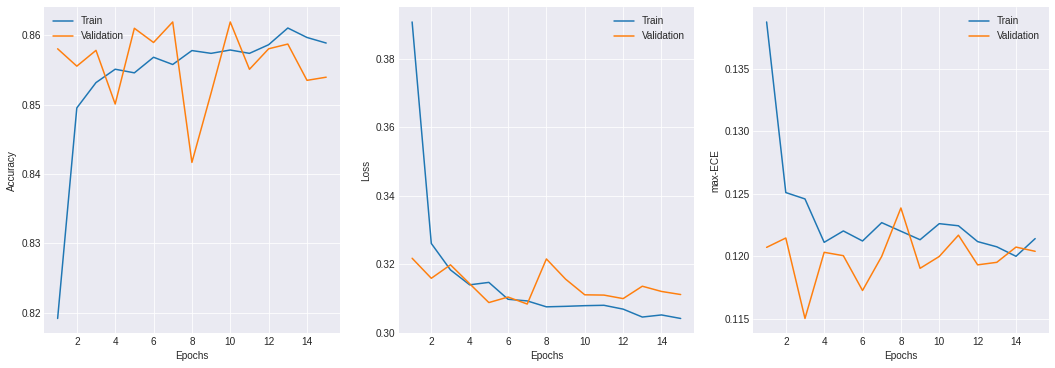

In [ ]:
## Plot history of best experiment

## Select best experiment
his_unique = his_best.loc[(his_best["gamma_rff"] == best_gamma) & (his_best["dim_rff"] == best_dim),:]

## Plot
fig, axis = plt.subplots(1,3, figsize = (18,6))

axis[0].plot(his_unique["epochs"], his_unique["accuracy"], label = "Train")
axis[0].plot(his_unique["epochs"], his_unique["val_accuracy"], label = "Validation")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].legend()

axis[1].plot(his_unique["epochs"], his_unique["loss"], label = "Train")
axis[1].plot(his_unique["epochs"], his_unique["val_loss"], label = "Validation")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].legend()

axis[2].plot(his_unique["epochs"], his_unique["maxECE_tf"], label = "Train")
axis[2].plot(his_unique["epochs"], his_unique["val_maxECE_tf"], label = "Validation")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("ECE-uniform")
axis[2].legend()

plt.savefig(dir + 'history_' + "qmc_sgd_adult" + '.pdf', bbox_inches='tight')
# plt.show()


del his_unique

In [ ]:
## Results calibration
gm_best

,dim_rff,gamma_rff,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,10,0.000100,0.202684,0.202684,0.320845,0.320845,0.858038,0.845541,0.860608
1,10,0.055644,0.197879,0.197879,0.315779,0.315779,0.854424,0.846906,0.860915
2,10,0.111189,0.205228,0.205228,0.322993,0.322993,0.854304,0.845996,0.856309
3,10,0.166733,0.203020,0.203020,0.317367,0.317367,0.855388,0.851456,0.850783
4,10,0.222278,0.196632,0.196632,0.310396,0.310396,0.860165,0.848726,0.858459
5,10,0.277822,0.198865,0.198865,0.315453,0.315453,0.858238,0.851228,0.856924
6,10,0.333367,0.205804,0.205804,0.321680,0.321680,0.852377,0.843722,0.849248
7,10,0.388911,0.209481,0.209481,0.332443,0.332443,0.854906,0.846906,0.855388
8,10,0.444456,0.226856,0.226856,0.352487,0.352487,0.839088,0.827116,0.834817
9,10,0.500000,0.211368,0.211368,0.331403,0.331403,0.847398,0.838944,0.843721


In [ ]:
## Results calibration
gm_ece_best

,dim_rff,gamma_rff,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,10,0.000100,Maximum,TV,Data,0.012391,0.014463,0.003492,0.712
1,10,0.000100,Maximum,TV,Uniform,0.012175,0.012421,0.003406,0.506
2,10,0.000100,CW,-,Uniform,0.020136,0.252405,0.007962,1.000
3,10,0.055644,Maximum,TV,Data,0.011906,0.013431,0.003386,0.657
4,10,0.055644,Maximum,TV,Uniform,0.010189,0.012179,0.003399,0.686
...,...,...,...,...,...,...,...,...,...
85,20,0.444456,Maximum,TV,Uniform,0.020714,0.013021,0.003537,0.018
86,20,0.444456,CW,-,Uniform,0.025658,0.244845,0.007876,1.000
87,20,0.500000,Maximum,TV,Data,0.014678,0.016268,0.003363,0.682
88,20,0.500000,Maximum,TV,Uniform,0.018808,0.013066,0.003413,0.051


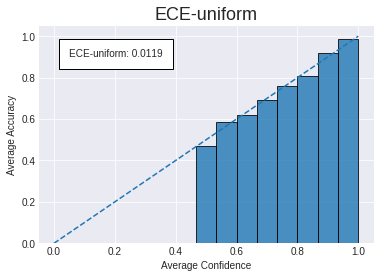

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax_best.loc[(dmax_best["gamma_rff"] == best_gamma) & (dmax_best["dim_rff"] == best_dim),:], diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)
plt.savefig(dir + 'dmax_' + "qmc_sgd_adult" + '.pdf', bbox_inches='tight')

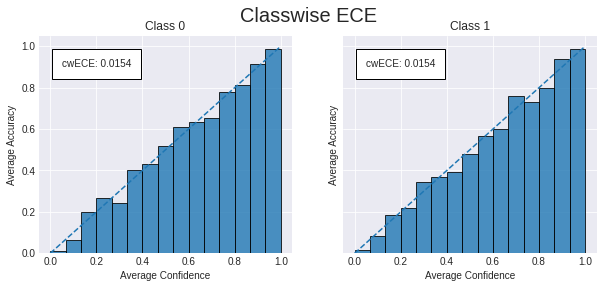

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw_best.loc[(dcw_best["gamma_rff"] == best_gamma) & (dcw_best["dim_rff"] == best_dim),:], diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)
plt.savefig(dir + 'dcw_' + "qmc_sgd_adult" + '.pdf', bbox_inches='tight')